In [ ]:
## Import Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import duckdb
#from pyspark import SparkConf, SparkContext
#from pyspark.sql import SparkSession, SQLContext

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import os
from dotenv import load_dotenv
load_dotenv()

## Get and Clean The Data

In [2]:
# Extract raw data
raw_data_path = os.getenv('RAW_DATA_PATH') # Your raw data path
data = pd.read_csv(raw_data_path)

# Generate "transaction" Table
data.columns = [col_name.lower().replace('no','_no').replace('name','_name') for col_name in data.columns]
data['date'] = pd.to_datetime(data['date'])
data['value'] = data['price'] * data['quantity']
data['fee'] = data['value'] * 0.02 # suppose fee is 2%

In [3]:
# Check Data Completeness and Data Type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   transaction_no  536350 non-null  object        
 1   date            536350 non-null  datetime64[ns]
 2   product_no      536350 non-null  object        
 3   product_name    536350 non-null  object        
 4   price           536350 non-null  float64       
 5   quantity        536350 non-null  int64         
 6   customer_no     536295 non-null  float64       
 7   country         536350 non-null  object        
 8   value           536350 non-null  float64       
 9   fee             536350 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 40.9+ MB


In [347]:
data['date'].max()

Timestamp('2019-12-09 00:00:00')

In [4]:
# Check that all each customer have only one country
duckdb.sql('SELECT customer_no, COUNT(distinct country) AS country_count FROM data GROUP BY customer_no HAVING COUNT(distinct country) > 1')

┌─────────────┬───────────────┐
│ customer_no │ country_count │
│   double    │     int64     │
├─────────────┴───────────────┤
│           0 rows            │
└─────────────────────────────┘

### Create "customers" Table

In [498]:
latest_date = data['date'].max()
scores = ['recency_score','frequency_score','monetery_score']
customers = duckdb.sql("""
    --sql
    SELECT *, 
        total_purchase / life_time AS frequency,
        (PERCENT_RANK() OVER (ORDER BY recency DESC)) AS recency_pct,
        (PERCENT_RANK() OVER (ORDER BY total_purchase / life_time)) AS frequency_pct,
        (PERCENT_RANK() OVER (ORDER BY total_spend)) AS monetery_pct,
        (total_spend - COALESCE(total_cancel,0)) / (life_time/30) AS cltv,
    FROM (
        SELECT customer_no, country,
            MIN(date) AS first_purchase_date,
            MAX(date) AS last_purchase_date,
            COUNT(DISTINCT product_no) AS total_product,
            COUNT(*) AS total_purchase,
            COUNT(DISTINCT DATETRUNC('MONTH', date)) AS month_active,
            COUNT(DISTINCT DATETRUNC('DAY', date)) AS day_active,        
            AVG(CASE WHEN value >= 0 THEN value END) AS avg_basket_size,
            SUM(CASE WHEN value >= 0 THEN value END) AS total_spend,
            SUM(CASE WHEN value < 0 THEN value *-1 END) AS total_cancel,
            DATE_PART('day', (SELECT MAX(date) FROM data) - MAX(date)) AS recency,
            DATE_PART('day', (SELECT MAX(date) FROM data) - MIN(date)) AS life_time
        FROM data
        GROUP BY customer_no, country
    ) a
    ;
""").df() \
    .assign(recency_score = lambda df: pd.qcut(df['recency_pct'], 5, labels=[1,2,3,4,5]).astype(int),
            frequency_score = lambda df: pd.qcut(df['frequency_pct'], 5, labels=[1,2,3,4,5]).astype(int),
            monetery_score = lambda df: pd.qcut(df['monetery_pct'], 5, labels=[1,2,3,4,5]).astype(int),
            average_score = lambda df: df[scores].mean(axis=1)) \
    .drop(columns=['recency_pct','frequency_pct','monetery_pct'])
scores = ['recency_score','frequency_score','monetery_score','average_score']

In [499]:
customers.head()

,customer_no,country,first_purchase_date,last_purchase_date,total_product,total_purchase,month_active,day_active,avg_basket_size,total_spend,total_cancel,recency,life_time,frequency,cltv,recency_score,frequency_score,monetery_score,average_score
0,16937.0,United Kingdom,2019-08-10,2019-08-10,1,1,1,1,5.97,5.97,NaN,121,121,0.008264,1.480165,2,1,1,1.333333
1,13775.0,United Kingdom,2019-07-20,2019-07-20,1,1,1,1,11.53,11.53,NaN,142,142,0.007042,2.435915,2,1,1,1.333333
2,12810.0,United Kingdom,2019-06-14,2019-06-14,1,1,1,1,11.98,11.98,NaN,178,178,0.005618,2.019101,2,1,1,1.333333
3,14435.0,United Kingdom,2019-12-08,2019-12-08,2,2,1,1,6.19,12.38,NaN,1,1,2.000000,371.400000,5,5,1,3.666667
4,12309.0,United Kingdom,2019-11-03,2019-11-03,1,1,1,1,12.86,12.86,NaN,36,36,0.027778,10.716667,3,1,1,1.666667


### Save new tables

In [504]:
data.to_csv('cleaned_data/transactions.csv', index=False)
customers.to_csv('cleaned_data/customers.csv', index=False)

In [510]:
data.to_excel('cleaned_data/transactions.xlsx', sheet_name='transactions')
customers.to_excel('cleaned_data/customers.xlsx', sheet_name='customers')

# Descriptive Analysis

In [460]:
# Transactions
data.describe().round(2)

,price,quantity,customer_no,value,fee
count,536350.00,536350.00,536295.00,536350.00,536350.00
mean,12.66,9.92,15227.89,112.39,2.25
std,8.49,216.66,1716.58,2277.38,45.55
min,5.13,-80995.00,12004.00,-840113.80,-16802.28
25%,10.99,1.00,13807.00,16.18,0.32
50%,11.94,3.00,15152.00,42.72,0.85
75%,14.09,10.00,16729.00,116.00,2.32
max,660.62,80995.00,18287.00,1002718.10,20054.36


In [474]:
# Customers
customers.drop(columns=scores).describe().round(2)

,customer_no,total_product,total_purchase,month_active,day_active,avg_basket_size,total_spend,total_cancel,recency,life_time,frequency,cltv
count,4738.00,4739.00,4739.00,4739.00,4739.00,4719.00,4719.00,1534.00,4739.00,4739.00,4738.00,4718.00
mean,15247.35,82.93,113.18,3.12,4.32,471.63,13343.08,1750.95,95.22,233.53,0.92,2191.71
std,1742.04,116.00,238.22,2.65,6.40,13244.68,54392.01,25491.44,102.23,115.07,10.00,11236.53
min,12004.00,1.00,1.00,1.00,1.00,5.97,5.97,5.97,0.00,0.00,0.00,-1485.91
25%,13743.25,17.00,19.00,1.00,1.00,49.55,1836.49,45.96,17.00,141.00,0.11,304.22
50%,15251.50,44.00,51.00,2.00,2.00,101.23,4826.72,121.80,52.00,261.00,0.29,825.13
75%,16746.75,101.00,132.00,4.00,5.00,150.81,11903.83,338.37,155.00,334.00,0.68,1853.60
max,18287.00,1786.00,7967.00,13.00,143.00,840113.80,2112282.03,840113.80,373.00,373.00,634.00,474463.50


In [475]:
# RFM Scores
customers[scores].describe().round(2)

,recency_score,frequency_score,monetery_score,average_score
count,4739.00,4739.00,4739.00,4739.00
mean,2.98,3.00,3.00,2.99
std,1.40,1.41,1.41,1.15
min,1.00,1.00,1.00,1.00
25%,2.00,2.00,2.00,2.00
50%,3.00,3.00,3.00,3.00
75%,4.00,4.00,4.00,4.00
max,5.00,5.00,5.00,5.00


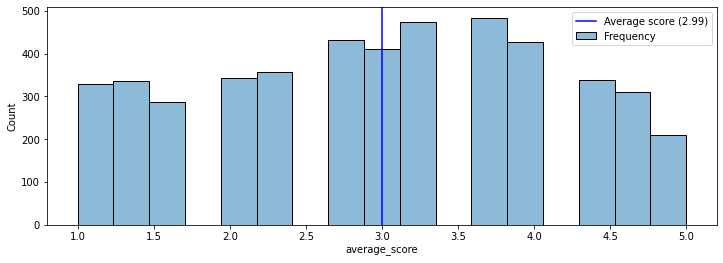

In [501]:
# RFM Score Distribution

plt.subplots(figsize=[12,4])
sns.histplot(customers, x='average_score', label='Frequency', alpha=0.5)
plt.axvline(customers['average_score'].median(), c='b', label=f'Average score ({round(customers.average_score.mean(),2)})')
plt.legend()
plt.show()

# Exploratory Analysis

### Customers and Sales by Customer Segment of Months Active

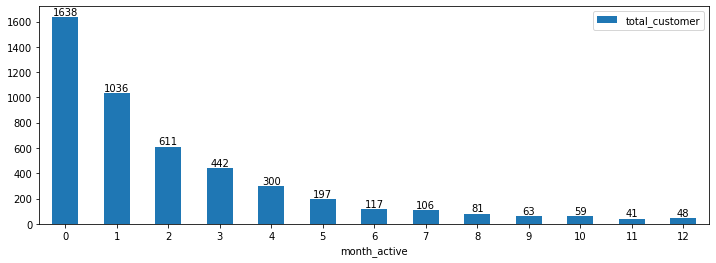

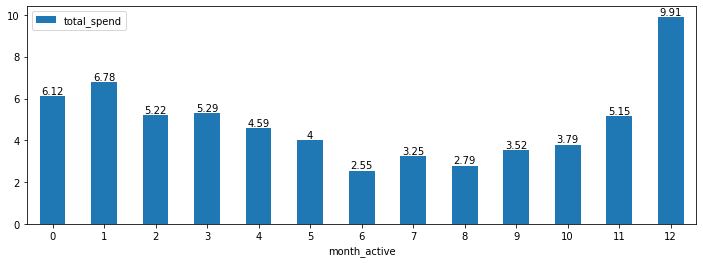

In [497]:
ax = duckdb.sql("""
    --sql
    SELECT month_active, COUNT(*) AS total_customer, ROUND(SUM(total_spend)/1000000,2) AS total_spend
    FROM customers
    GROUP BY month_active
    ORDER BY 1;
""").df().set_index('month_active')[['total_customer']].plot.bar(figsize=[12,4])
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_xticklabels(ax.get_xticks(), rotation = 0);
ax = duckdb.sql("""
    --sql
    SELECT month_active, COUNT(*) AS total_customer, ROUND(SUM(total_spend)/1000000,2) AS total_spend
    FROM customers
    GROUP BY month_active
    ORDER BY 1;
""").df().set_index('month_active')[['total_spend']].plot.bar(figsize=[12,4])
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_xticklabels(ax.get_xticks(), rotation = 0);

### Top 5 Most Sales Product

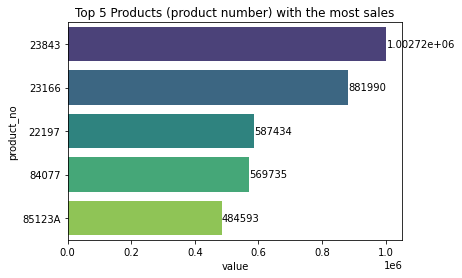

In [458]:
# Top 5 product

ax = sns.barplot(data=data.query('quantity > 0').groupby('product_no')[['value']].sum().sort_values('value', ascending=False).head(5).reset_index(),
            x='value', y='product_no', palette='viridis')
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Top 5 Products (product number) with the most sales')
plt.show()

### Proportion of Sales by Country

In [7]:
sales_by_country = data.groupby('country')[['value']].sum().sort_values('value', ascending=False).astype(int).reset_index()
sales_by_country_trans = duckdb.sql("SELECT IF(value > 1000000, country, 'other') AS country, value FROM sales_by_country").df() \
    .groupby('country')[['value']].sum().sort_values('value', ascending=False).astype(int).reset_index()

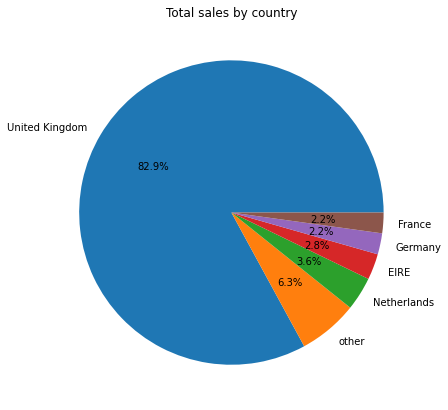

In [37]:
plt.subplots(facecolor='white', figsize=[7,7])
plt.pie(x=sales_by_country_trans.value, labels=sales_by_country_trans.country, autopct='%1.1f%%')
plt.title('Total sales by country')
plt.show()

### Contribution of Metrics by Day-of-Week Over Time

In [149]:
new_customer = customers \
    .groupby('first_purchase_date')[['customer_no']] \
    .count() \
    .reset_index() \
    .rename(columns={'first_purchase_date':'date', 'customer_no':'new_customer'}) \
    .set_index('date') \
    .resample('1d').sum().reset_index()

new_customer_country = customers \
    .groupby('first_purchase_date','country')[['customer_no']] \
    .count() \
    .reset_index() \
    .rename(columns={'first_purchase_date':'date', 'customer_no':'new_customer'}) \
    .set_index('date') \
    .resample('1d').sum().reset_index()

daily_total = duckdb.sql("""
    --sql
    SELECT
        date,
        COUNT(*) AS transactions,
        COUNT(DISTINCT customer_no) AS unique_customer,
        SUM(CASE WHEN value >= 0 THEN value END) AS total_spend,
        SUM(CASE WHEN value < 0 THEN value *-1 END) AS total_cancel
    FROM data
    GROUP BY 1
    ORDER BY 1
;""").df() \
    .set_index('date') \
    .resample('1d').sum().reset_index() \
    .merge(new_customer.set_index('date'), how='left', left_on='date', right_index=True) \
    .assign(day = lambda df: df['date'].dt.dayofweek.add(1).astype(str) +'-'+ df['date'].dt.day_name(),
           year_week = lambda df: df['date'].dt.strftime('%Y-w%U'))

weekly_total = daily_total.set_index('date')[['transactions','total_spend','total_cancel','new_customer']] \
    .resample('1W').sum() \
    .reset_index() \
    .assign(year_week = lambda df: df['date'].dt.strftime('%Y-w%U'),
           year = lambda df: df['date'].dt.year)

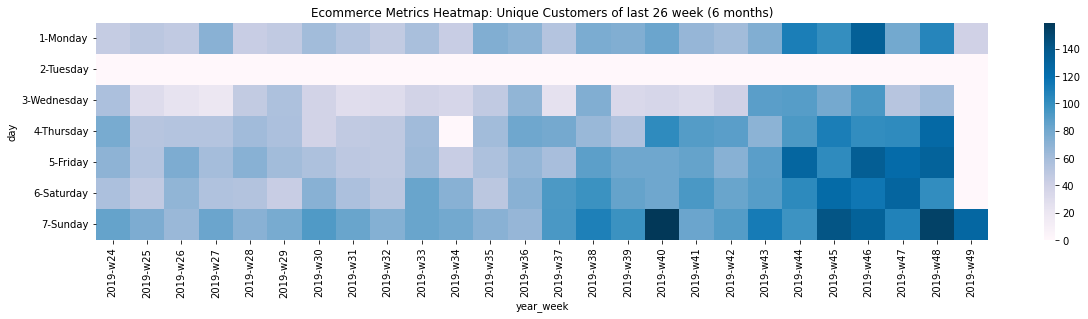

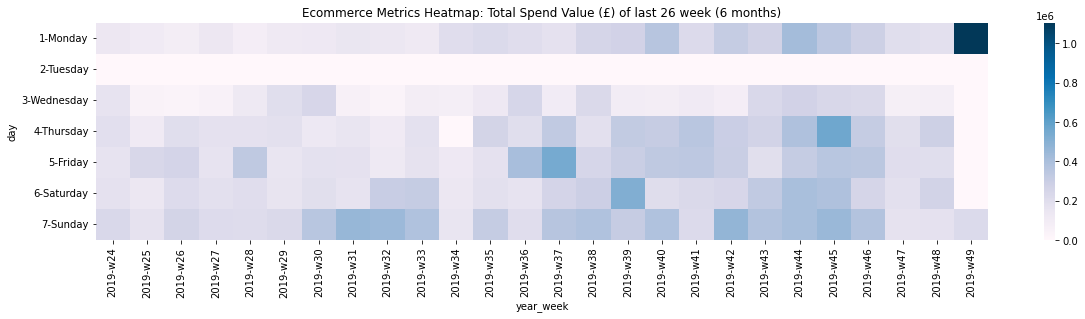

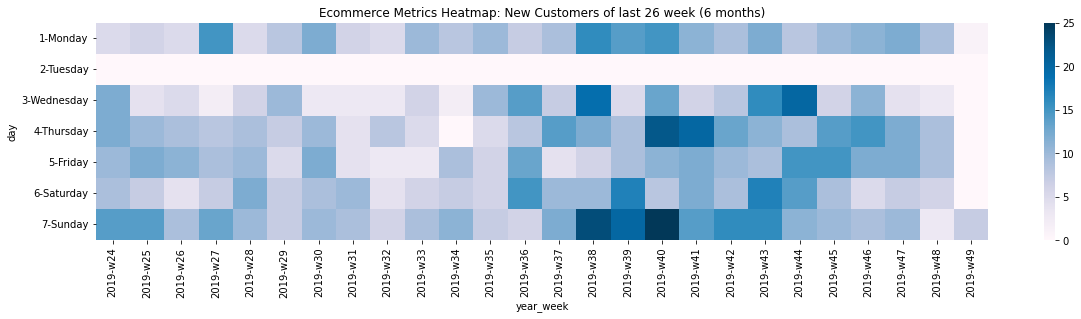

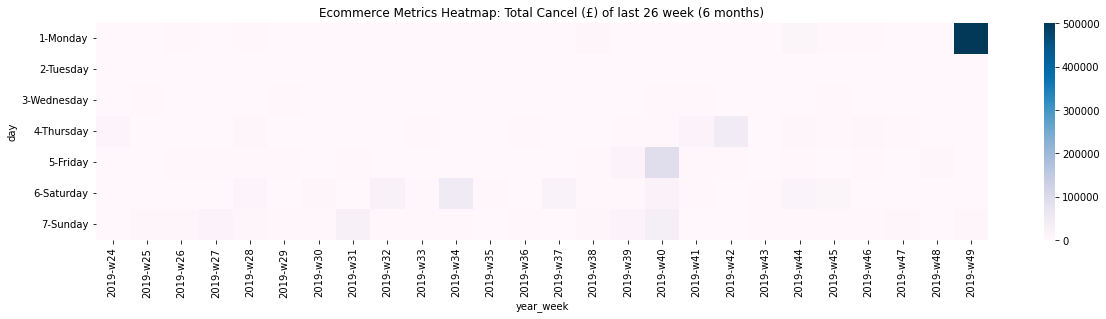

In [251]:
plt.subplots(figsize=[20,4])
sns.heatmap(daily_pivot.query('metrics=="unique_customer"').iloc[-26:,:].drop(columns='metrics').transpose(), cmap='PuBu')
plt.title('Ecommerce Metrics Heatmap: Unique Customers of last 26 week (6 months)')
plt.show()
plt.subplots(figsize=[20,4])
sns.heatmap(daily_pivot.query('metrics=="total_spend"').iloc[-26:,:].drop(columns='metrics').transpose(), cmap='PuBu')
plt.title('Ecommerce Metrics Heatmap: Total Spend Value (£) of last 26 week (6 months)')
plt.show()
plt.subplots(figsize=[20,4])
sns.heatmap(daily_pivot.query('metrics=="new_customer"').iloc[-26:,:].drop(columns='metrics').transpose(), cmap='PuBu')
plt.title('Ecommerce Metrics Heatmap: New Customers of last 26 week (6 months)')
plt.show()
plt.subplots(figsize=[20,4])
sns.heatmap(daily_pivot.query('metrics=="total_cancel"').iloc[-26:,:].drop(columns='metrics').transpose(), cmap='PuBu')
plt.title('Ecommerce Metrics Heatmap: Total Cancel (£) of last 26 week (6 months)')
plt.show()